In [ ]:
%load_ext autoreload
%autoreload 2

import itertools
from pathlib import Path
from typing import Any, Callable, Iterable

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import tqdm
import torch
import triton

import bench

pd.set_option("display.max_rows", 200)
matplotlib.rcParams.update({"axes.spines.right": False, "axes.spines.top": False, "legend.frameon": False})

META = dict(
    device=torch.cuda.get_device_name(0),
    torch_version=torch.__version__,
    triton_version=triton.__version__,
    cuda_version=torch.version.cuda,
)

def generate_configs(_filter: Callable[..., bool] | None = None, **axes: list[Any]) -> Iterable[triton.Config]:
    for values in itertools.product(*axes.values()):
        d = dict(zip(axes.keys(), values))
        if _filter is not None and not _filter(d):
            continue  # skip
        args = dict(kwargs=d)
        if "num_stages" in d:
            args["num_stages"] = d.pop("num_stages")
        if "num_warps" in d:
            args["num_warps"] = d.pop("num_warps")
        yield triton.Config(**args)


def sweep_benchmarks(benchmark: bench.Benchmark,
                     kernel: triton.runtime.Autotuner,
                     configs: Iterable[triton.Config],
                     settings: Iterable[bench.Settings]) -> Iterable[dict[str, Any]]:
    original_configs = kernel.configs
    try:
        # Settings > Config gives better results than Config > Settings
        progress = tqdm.tqdm(list(itertools.product(settings, configs)))
        for s, config in progress:
            try:
                progress.set_postfix_str(f"{s.__dict__} {config.all_kwargs()}")
                kernel.configs = [config]
                result = benchmark.run(s)
                yield {**s.__dict__, **config.all_kwargs(), **result.__dict__, **META}
            except (triton.runtime.errors.OutOfResources, bench.UnsupportedSettings):
                pass
    finally:
        kernel.configs = original_configs


benchmark_to_kernel = dict(mv=bench.kernel__mv, mm=bench.kernel__mm, mv_lut8=bench.kernel__mv_lut, mm_lut8=bench.kernel__mm_lut)

def load_sweep_benchmarks(name: str, configs: Iterable[triton.Config], settings: Iterable[bench.Settings], reload: bool = False) -> pd.DataFrame:
    cache_path = Path("results") / f"{name}.json.gz"
    if not cache_path.exists() or reload:
        df = pd.DataFrame.from_records(sweep_benchmarks(bench.BENCHMARKS[name], benchmark_to_kernel[name], configs, settings))
        cache_path.parent.mkdir(parents=True, exist_ok=True)
        df.to_json(cache_path, orient="records")
    df = pd.read_json(cache_path, orient="records")
    df["gb_s"] = df["bytes_rw"] / df["time_s"] / 1e9
    df["tflops"] = df["ops"] / df["time_s"] / 1e12
    return df

model_dims = [3072, 4096, 6144, 8192]
batch_sizes = [16, 64, 256]
bits_range = [1, 2, 4, 8]

## `mv`

In [4]:
df = load_sweep_benchmarks(
    "mv",
    configs=generate_configs(
        BLOCK_SIZE=[256, 512, 1024, 2048, 4096, 8192],
        num_stages=[1, 2, 3],
        num_warps=[1, 2, 4, 8, 16],
    ),
    settings=[
        bench.Settings(1, dim, dim, g=64, bits=16, copies=100, reps=100)
        for dim in model_dims
    ],
)

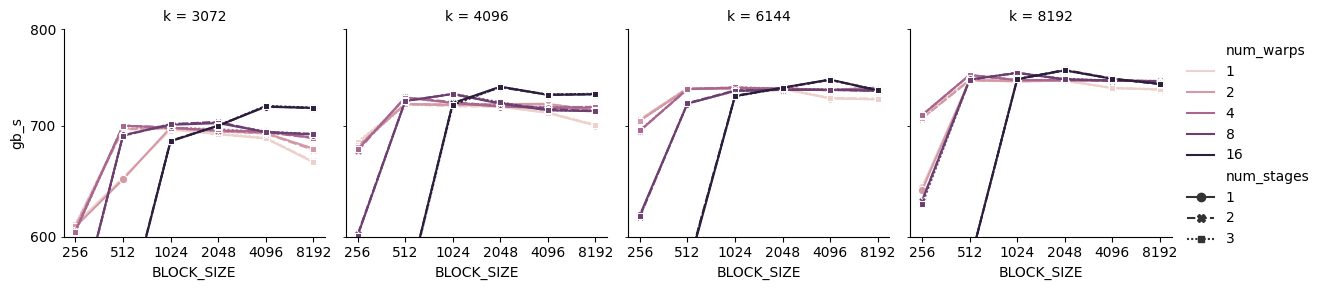

In [5]:
g = sns.relplot(data=df, y="gb_s", col="k", x="BLOCK_SIZE", hue="num_warps", style="num_stages",
                hue_norm=matplotlib.colors.LogNorm(), kind="line", markers=True, height=3)
for ax in g.axes.flatten():
    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter("{x:.0f}")
    ax.yaxis.set_minor_formatter("{x:.0f}")
    ax.xaxis.set_major_formatter("{x:.0f}")
    ax.set_ylim((600, 800))

## `mm`

In [6]:
block_sizes = [16, 32, 64, 128, 256, 512]
df = load_sweep_benchmarks(
    "mm",
    configs=generate_configs(
        BLOCK_SIZE_M=block_sizes,
        BLOCK_SIZE_N=block_sizes,
        BLOCK_SIZE_K=block_sizes,
        GROUP_SIZE_M=[8],  # low impact
        num_stages=[3],  # consistently best
        num_warps=[1, 2, 4, 8],
        # large blocks are too slow to compile
        _filter=lambda c: c["BLOCK_SIZE_M"] * c["BLOCK_SIZE_N"] * c["BLOCK_SIZE_K"] <= 2**17,
    ),
    settings=[
        bench.Settings(m, dim, dim, g=64, bits=16, copies=100, reps=100)
        for m in batch_sizes
        for dim in model_dims
    ],
)

In [53]:
# for _, g in df.groupby(["m", "k"]):
#     display(g.sort_values(by="tflops", ascending=False).head(10).drop(
#         columns=["n", "g", "copies", "reps", "num_ctas", "name", "bytes_rw", "ops", "GROUP_SIZE_M", "num_stages", "time_s"]
#     ).style.hide())

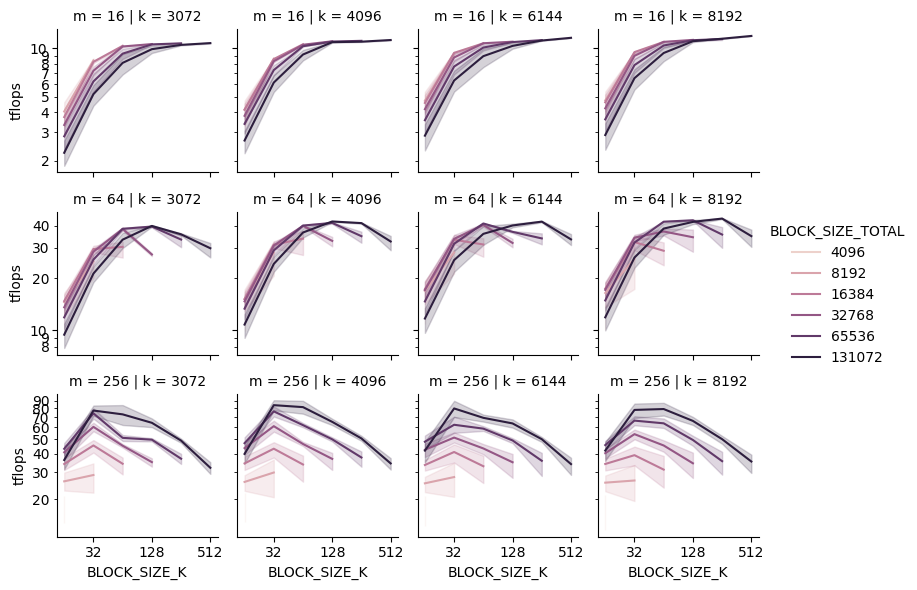

In [7]:
g = sns.relplot(data=df.pipe(lambda d: d.assign(BLOCK_SIZE_TOTAL=d["BLOCK_SIZE_M"] * d["BLOCK_SIZE_N"] * d["BLOCK_SIZE_K"])),
                y="tflops", row="m", col="k", x="BLOCK_SIZE_K", hue="BLOCK_SIZE_TOTAL",
                hue_norm=matplotlib.colors.LogNorm(), kind="line", markers=True, height=2,
                facet_kws=dict(sharey="row"))
for ax in g.axes.flatten():
    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter("{x:.0f}")
    ax.yaxis.set_minor_formatter("{x:.0f}")
    ax.xaxis.set_major_formatter("{x:.0f}")

## `mv_lut8`

In [10]:
df = load_sweep_benchmarks(
    "mv_lut8",
    configs=generate_configs(
        BLOCK_SIZE=[128, 256, 512, 1024, 2048, 4096],
        num_stages=[1, 3],
        num_warps=[1, 2, 4, 8],
    ),
    settings=[
        bench.Settings(1, dim, dim, g=64, bits=bits, copies=100, reps=100)
        for bits in bits_range
        for dim in model_dims
    ],
)

In [12]:
df.groupby(["k", "bits"]).apply(lambda d: d.loc[d["gb_s"].idxmax()], include_groups=False)[["BLOCK_SIZE", "num_stages", "num_warps", "gb_s"]]

BLOCK_SIZE  num_stages  num_warps        gb_s
k    bits                                               
3072 1            128           1          1  226.522441
     2            256           3          1  340.853381
     4            512           3          1  524.919786
     8           1024           3          1  629.364266
4096 1            256           1          1  316.851930
     2            512           3          1  469.441624
     4           1024           1          1  624.643582
     8           2048           3          1  672.711763
6144 1            256           3          1  390.547958
     2            512           1          1  555.127626
     4           1024           3          1  663.104060
     8           2048           3          1  710.762072
8192 1            256           1          1  464.796380
     2            512           1          1  593.887964
     4           1024           3          1  715.270649
     8           2048           1          1  730.196695

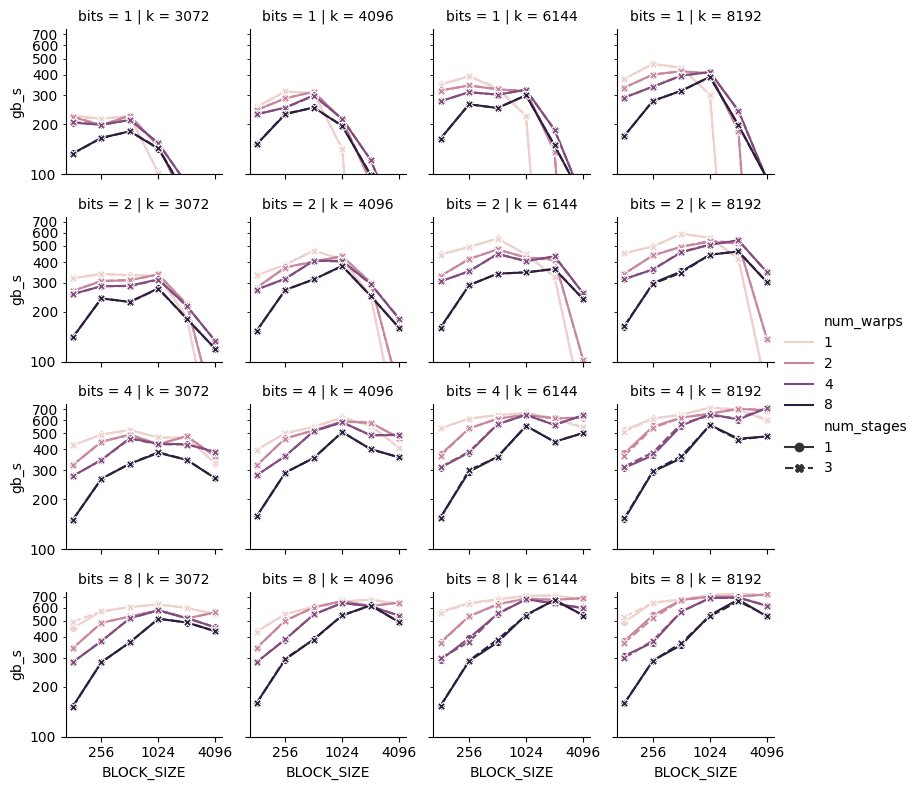

In [9]:
g = sns.relplot(data=df, y="gb_s", row="bits", col="k", x="BLOCK_SIZE", hue="num_warps", style="num_stages",
                hue_norm=matplotlib.colors.LogNorm(), kind="line", markers=True, height=2,
                facet_kws=dict(sharey="row"))
for ax in g.axes.flatten():
    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter("{x:.0f}")
    ax.yaxis.set_minor_formatter("{x:.0f}")
    ax.xaxis.set_major_formatter("{x:.0f}")
    ax.set_ylim((100, 750))

## `mm_lut8`

In [170]:
block_sizes = [8, 16, 32, 64, 128, 256]
df = load_sweep_benchmarks(
    "mm_lut8",
    configs=generate_configs(
        BLOCK_SIZE_M=block_sizes,
        BLOCK_SIZE_N=block_sizes,
        BLOCK_SIZE_K=block_sizes,
        GROUP_SIZE_M=[8],
        num_stages=[1],  # consistently best
        num_warps=[1, 2, 4],
        # large blocks are too slow to compile
        _filter=lambda c: c["BLOCK_SIZE_M"] * c["BLOCK_SIZE_N"] * c["BLOCK_SIZE_K"] <= 2**16 and c["BLOCK_SIZE_K"] >= 64,
    ),
    settings=[
        bench.Settings(m, dim, dim, g=64, bits=bits, copies=100, reps=100)
        for bits in bits_range
        for m in batch_sizes
        for dim in model_dims
    ],
    # reload=True,
)

In [171]:
(df.pipe(lambda d: d[d.bits.isin([1, 4])]).groupby(["bits", "k", "m"])
 .apply(lambda d: d.loc[d["tflops"].idxmax()], include_groups=False)
 [["BLOCK_SIZE_M", "BLOCK_SIZE_N", "BLOCK_SIZE_K", "num_warps", "tflops"]])

BLOCK_SIZE_M  BLOCK_SIZE_N  BLOCK_SIZE_K  num_warps     tflops
bits k    m                                                                  
1    3072 16             16             8           128          4  24.252709
          64             16            16            64          1  46.043993
          256            16            32            64          2  53.047690
     4096 16             16            16           128          4  32.524030
          64             16            16            64          1  52.718779
          256            16            32            64          2  54.446725
     6144 16             16             8            64          1  40.096778
          64             32            32            64          2  49.539684
          256            16            32            64          2  57.705666
     8192 16             16            16            64          1  47.500612
          64             16            16            64          1  54.777366
          256            16            32            64          2  54.229496
4    3072 16             16             8           256          2  19.819381
          64             16            16           128          1  44.049621
          256            32            32            64          1  76.775057
     4096 16             16             8           256          2  24.591347
          64             16            16           128          1  50.051360
          256            32            32            64          1  78.193601
     6144 16             16             8           256          1  29.170298
          64             32            16            64          1  59.212107
          256            32            32            64          1  62.481360
     8192 16             16             8           256          1  33.161776
          64             32            16            64          1  65.922263
          256            32            32            64          1  70.464372

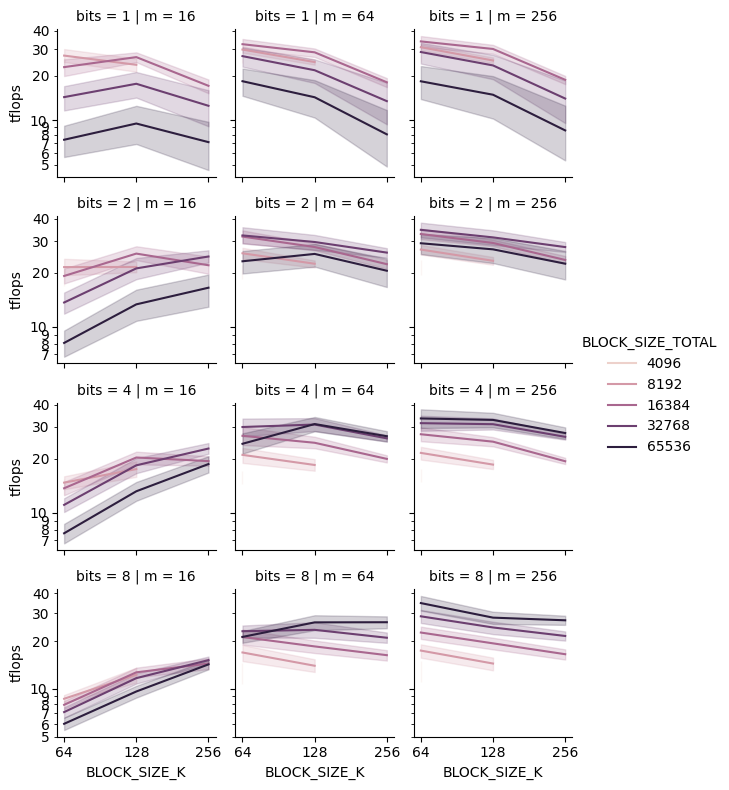

In [172]:
g = sns.relplot(data=df.pipe(lambda d: d.assign(BLOCK_SIZE_TOTAL=d["BLOCK_SIZE_M"] * d["BLOCK_SIZE_N"] * d["BLOCK_SIZE_K"])),
                y="tflops", row="bits", col="m", x="BLOCK_SIZE_K", hue="BLOCK_SIZE_TOTAL",
                hue_norm=matplotlib.colors.LogNorm(), kind="line", markers=True, height=2,
                facet_kws=dict(sharey="row"))
for ax in g.axes.flatten():
    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter("{x:.0f}")
    ax.yaxis.set_minor_formatter("{x:.0f}")
    ax.xaxis.set_major_formatter("{x:.0f}")

In [173]:
# Find best config sets for autotune

task_keys = ["m", "k", "bits"]
config_keys = ["BLOCK_SIZE_M", "BLOCK_SIZE_N", "BLOCK_SIZE_K", "num_warps"]
dfm = (df
    .pipe(lambda d: d.assign(task_name=d.apply(lambda s: ", ".join(f"{k}={s[k]}" for k in task_keys), axis=1)))
    .pipe(lambda d: d.assign(config_name=d.apply(lambda s: ", ".join(f"{k}={s[k]}" for k in config_keys), axis=1)))
    .pivot(index="task_name", columns="config_name", values="tflops")
)


def select_configset_greedy(scores: np.ndarray, count: int) -> np.ndarray:
    """
    scores :: (n_tasks, n_configs, float)
    returns :: (count)  -- indices into configs
    """
    selected = []
    # best score per task given current selected set
    current_scores = np.zeros(scores.shape[0], dtype=scores.dtype)
    for _ in range(count):
        # marginal gain for adding each config
        gains = np.sum(np.maximum(current_scores[:, None], scores) - current_scores[:, None], axis=0)
        gains[selected] = -np.inf
        best = int(np.argmax(gains))
        selected.append(best)
        current_scores = np.maximum(current_scores, scores[:, best])
    return np.array(selected)


def select_configset_random(scores: np.ndarray, count: int, iters: int) -> np.ndarray:
    n_configs = scores.shape[1]
    best, best_value = None, -np.inf
    for _ in range(iters):
        candidate = np.random.choice(n_configs, size=count, replace=False)
        if best_value < (value := objective_value(scores, candidate)):
            best, best_value = candidate, value
    return np.sort(best)


def select_configset_local_random(scores: np.ndarray, count: int, iters: int, local_iters: int) -> np.ndarray:
    n_configs = scores.shape[1]
    best, best_value = None, -np.inf
    for _ in range(iters):
        config = np.random.choice(n_configs, size=count, replace=False)
        config_value = objective_value(scores, config)
        if best_value < config_value:
            best, best_value = config, config_value
        for _ in range(local_iters):
            # try to improve `config` by swapping out one element
            # - pick the element to remove uniformly at random, but replace based on 'best gain'
            candidate = np.delete(config, np.random.randint(count))
            task_scores = np.max(scores[:, candidate], axis=1)
            gains = np.sum(np.maximum(task_scores[:, None], scores) - task_scores[:, None], axis=0)
            config = np.append(candidate, int(np.argmax(gains)))
            config_value = objective_value(scores, config)
            if best_value < config_value:
                best, best_value = config, config_value
    return np.sort(best)



def objective_value(scores: np.ndarray, selected: np.ndarray) -> float:
    return float(np.mean(np.max(scores[:, selected], axis=1)))


# objective = dfm  # unnormalised
objective = (dfm / dfm.max(axis=1).to_numpy()[:, None])  # normalised (vs best per task)

count = 4
print("Greedy")
settings = select_configset_greedy(objective.to_numpy(), count)
print(objective_value(objective.to_numpy(), settings))
display(dfm.columns[settings].tolist())

print("Random")
settings = select_configset_random(objective.to_numpy(), count, 10000)
print(objective_value(objective.to_numpy(), settings))
display(dfm.columns[settings].tolist())

print("Local-Random")
settings = select_configset_local_random(objective.to_numpy(), count, 100, 100)
print(objective_value(objective.to_numpy(), settings))
display(dfm.columns[settings].tolist())

print("Scipy")
result = scipy.optimize.differential_evolution(
    lambda x: -objective_value(objective.to_numpy(), x.astype(int)),
    bounds=[(0, dfm.shape[1]-1)]*count, maxiter=10000, polish=True)
settings = np.sort(result.x.astype(int))
print(objective_value(objective.to_numpy(), settings))
display(dfm.columns[settings].tolist())

Greedy
0.93132376106271


['BLOCK_SIZE_M=16, BLOCK_SIZE_N=16, BLOCK_SIZE_K=128, num_warps=1',
 'BLOCK_SIZE_M=16, BLOCK_SIZE_N=16, BLOCK_SIZE_K=64, num_warps=1',
 'BLOCK_SIZE_M=32, BLOCK_SIZE_N=32, BLOCK_SIZE_K=64, num_warps=1',
 'BLOCK_SIZE_M=16, BLOCK_SIZE_N=8, BLOCK_SIZE_K=256, num_warps=2']

Random


0.9076742598888415


['BLOCK_SIZE_M=16, BLOCK_SIZE_N=16, BLOCK_SIZE_K=128, num_warps=4',
 'BLOCK_SIZE_M=16, BLOCK_SIZE_N=16, BLOCK_SIZE_K=256, num_warps=2',
 'BLOCK_SIZE_M=16, BLOCK_SIZE_N=16, BLOCK_SIZE_K=64, num_warps=1',
 'BLOCK_SIZE_M=32, BLOCK_SIZE_N=32, BLOCK_SIZE_K=64, num_warps=1']

Local-Random
0.93132376106271


['BLOCK_SIZE_M=16, BLOCK_SIZE_N=16, BLOCK_SIZE_K=128, num_warps=1',
 'BLOCK_SIZE_M=16, BLOCK_SIZE_N=16, BLOCK_SIZE_K=64, num_warps=1',
 'BLOCK_SIZE_M=16, BLOCK_SIZE_N=8, BLOCK_SIZE_K=256, num_warps=2',
 'BLOCK_SIZE_M=32, BLOCK_SIZE_N=32, BLOCK_SIZE_K=64, num_warps=1']

Scipy
0.93132376106271


['BLOCK_SIZE_M=16, BLOCK_SIZE_N=16, BLOCK_SIZE_K=128, num_warps=1',
 'BLOCK_SIZE_M=16, BLOCK_SIZE_N=16, BLOCK_SIZE_K=64, num_warps=1',
 'BLOCK_SIZE_M=16, BLOCK_SIZE_N=8, BLOCK_SIZE_K=256, num_warps=2',
 'BLOCK_SIZE_M=32, BLOCK_SIZE_N=32, BLOCK_SIZE_K=64, num_warps=1']